<a href="https://colab.research.google.com/github/Mathan-S-7/RLHF_Labs/blob/main/Lab1%2CLab2%2CLab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
k=10
num_problems = 2000

q_star = np.random.normal(0,1, (num_problems,k))
arms = [0] * k

for i in range(10):
  arms[i] = np.random.normal(q_star[0,i], 1, num_problems)

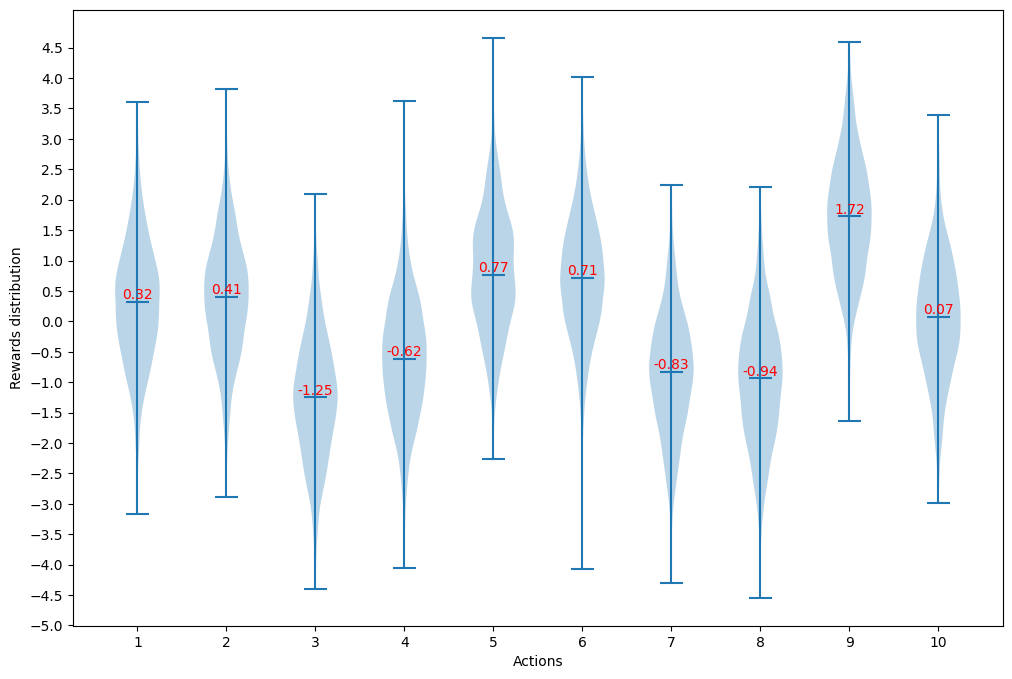

In [ ]:
plt.figure(figsize=(12, 8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1, 11))
plt.yticks(np.arange(-5, 5, 0.5))

# Violin plot
plt.violinplot(arms, positions=range(1, 11), showmedians=True)

# Compute and annotate medians
medians = [np.median(arms[i]) for i in range(10)]
for i, median in enumerate(medians, start=1):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=10, color='red')

# Show plot
plt.show()

In [ ]:
def bandit(action, problem):
  return np.random.normal(q_star[problem, action], 1)

In [ ]:
def simple_max(Q, N, t):
  return np.random.choice(np.flatnonzero(Q == Q.max()))

In [ ]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha=0, argmax_func=simple_max):
  rewards = np.zeros(steps)
  actions = np.zeros(steps)

  for i in tqdm(range(num_problems)):
    Q = np.ones(k)
    N = np.zeros(k)
    best_action = np.argmax(q_star[i])

    for t in range(steps):
      if np.random.rand() < epsilon:
        a = np.random.randint(k)
      else:
        a = argmax_func(Q, N, t)

      reward = bandit(a, i)

      N[a] += 1

      if alpha > 0:
        Q[a] = Q[a] + (reward - Q[a]) * alpha
      else:
        Q[a] = Q[a] + (reward - Q[a]) / N[a]

      rewards[t] += reward

      if a == best_action:
        actions[t] += 1

  return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [ ]:
ep_0, ac_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0)
ep_01, ac_01 = simple_bandit(k=10, epsilon=0.01, steps=1000, initial_Q=0)
ep_1, ac_1 = simple_bandit(k=10, epsilon=0.1, steps=1000, initial_Q=0)

100%|██████████| 2000/2000 [01:00<00:00, 32.89it/s]


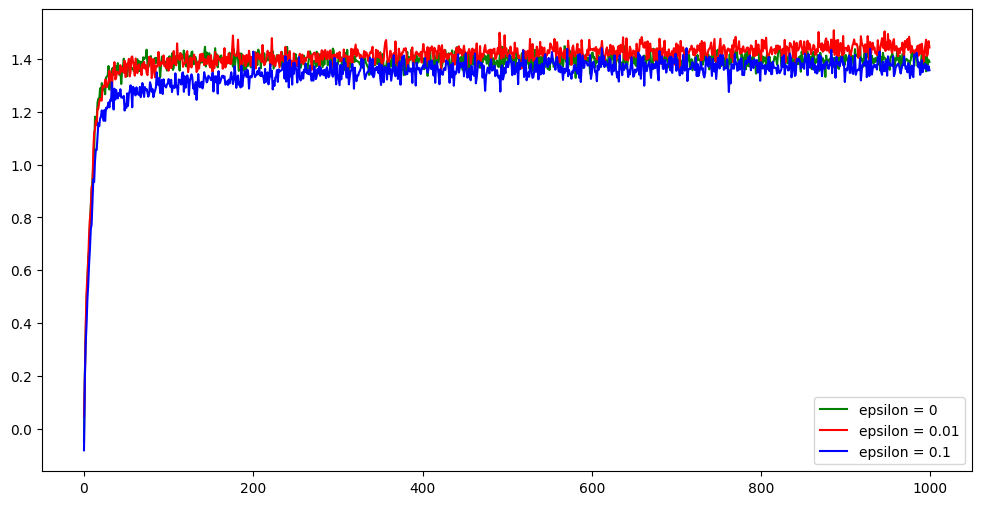

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ep_0, 'g', label='epsilon = 0')
plt.plot(ep_01, 'r', label='epsilon = 0.01')
plt.plot(ep_1, 'b', label='epsilon = 0.1')
plt.legend()
plt.show()

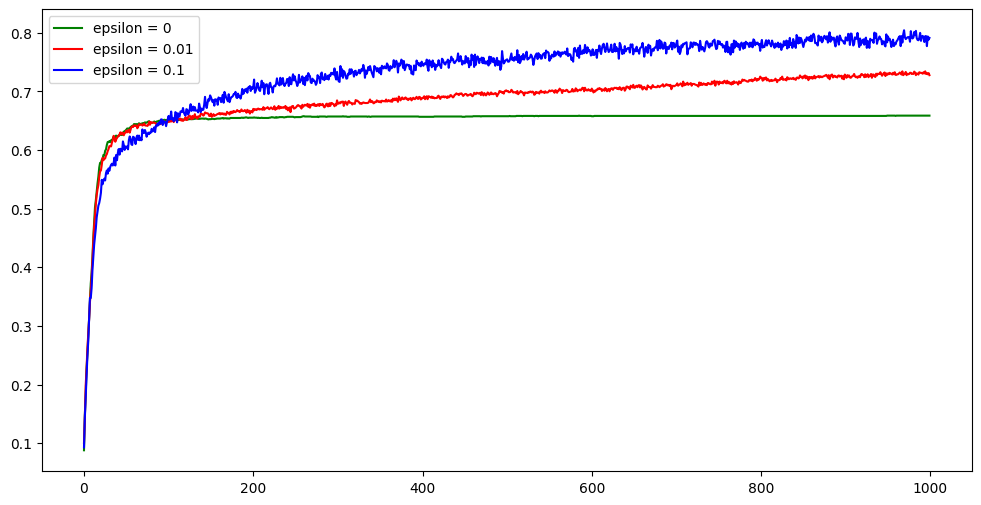

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ac_0, 'g', label='epsilon = 0')
plt.plot(ac_01, 'r', label='epsilon = 0.01')
plt.plot(ac_1, 'b', label='epsilon = 0.1')
plt.legend()
plt.show()

In [ ]:
opt_0, ac_opt_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=5, alpha=0.2)

100%|██████████| 2000/2000 [01:02<00:00, 32.14it/s]


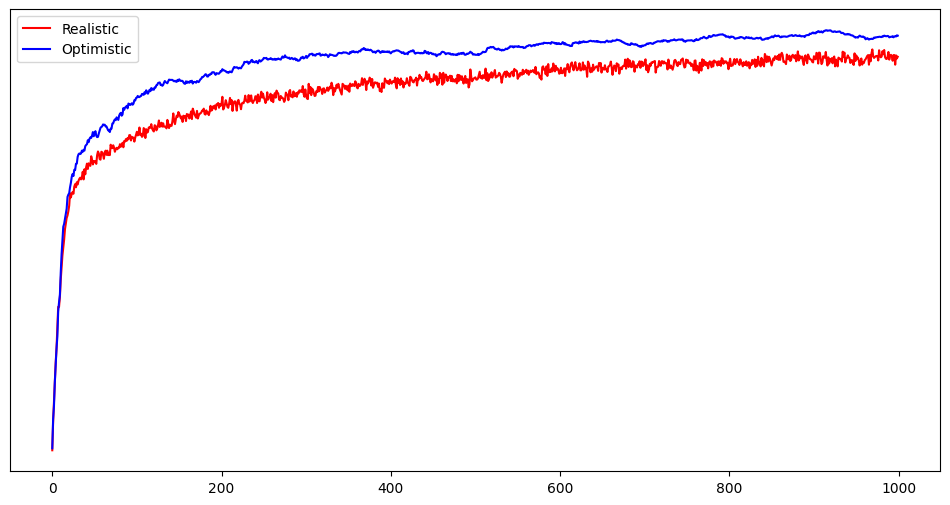

In [ ]:
plt.figure(figsize=(12, 6))
plt.yticks(np.arange(0.3,0.2))
plt.plot(ac_1, 'r', label='Realistic')
plt.plot(ac_opt_0, 'b', label='Optimistic')
plt.legend()
plt.show()

In [ ]:
def ucb(Q,N,t):
  c = 2
  if N.min() == 0:
    return np.random.choice(np.flatnonzero(N == N.min()))

  M = Q + c * np.sqrt(np.divide(np.log(t), N))
  return np.argmax(M)

In [ ]:
ucb_2, ac_ucb_2 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0, argmax_func=ucb)

100%|██████████| 2000/2000 [00:42<00:00, 46.75it/s]


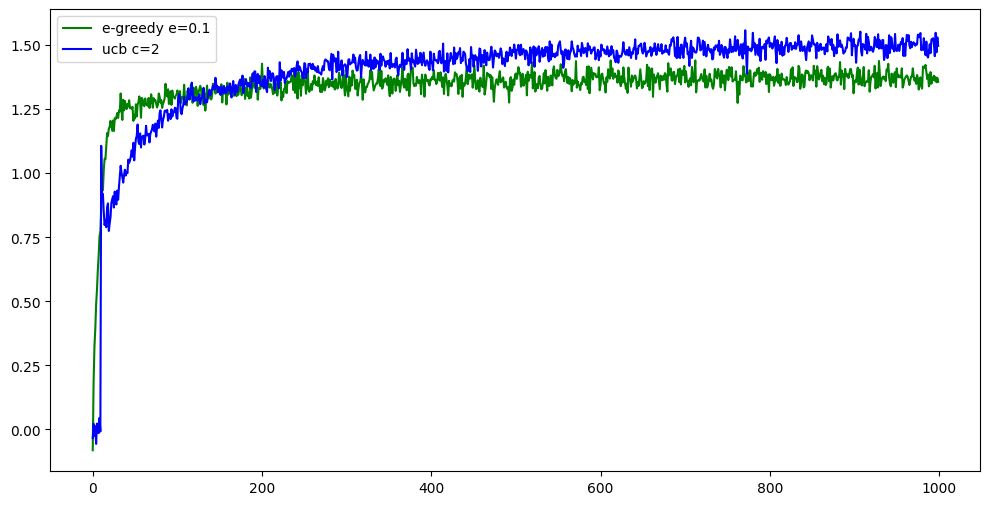

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ep_1, 'g', label='e-greedy e=0.1')
plt.plot(ucb_2, 'b', label='ucb c=2')
plt.legend()
plt.show()

In [ ]:
def softmax(x):
  e_x = np.exp(x - np.max(x))
  M = e_x / e_x.sum()

  return np.argmax(M), M

In [ ]:
def gradient_bandit(k,steps, alpha, initial_Q, is_baseline=True):
  rewards = np.zeros(steps)
  actions = np.zeros(steps)

  for i in tqdm(range(num_problems)):
    Q = np.zeros(k) * initial_Q
    N = np.zeros(k)
    R = np.zeros(k)
    H = np.zeros(k)
    pi = np.zeros(k)
    best_action = np.argmax(q_star[i])

    for t in range(steps):
      a, pi = softmax(H)

      reward = bandit(a, i)

      N[a] += 1
      Q[a] = Q[a] + (reward - Q[a]) / N[a]

      for action_i in range(k):
        if action_i == a:
          H[a] = H[a] + alpha * (reward - R[a]) * (1 - pi[a])
        else:
          H[action_i] = H[action_i] - alpha * (reward - R[action_i] * pi[action_i])

      if is_baseline == True:
        R[a] = Q[a]

      rewards[t] += reward
      if a == best_action:
        actions[t] += 1

  return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [ ]:
sft_4, ac_sft_4 = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=False)
sft_4_baseline, ac_sft_4_baseline = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=True)

sft_1, ac_sft_1 = gradient_bandit(k=10, steps=1000, alpha=0.1, initial_Q=0, is_baseline=False)
sft_1_baseline, ac_sft_1_baseline = gradient_bandit(k=10, steps=1000, alpha=0.1, initial_Q=0, is_baseline=True)

100%|██████████| 2000/2000 [01:04<00:00, 31.07it/s]


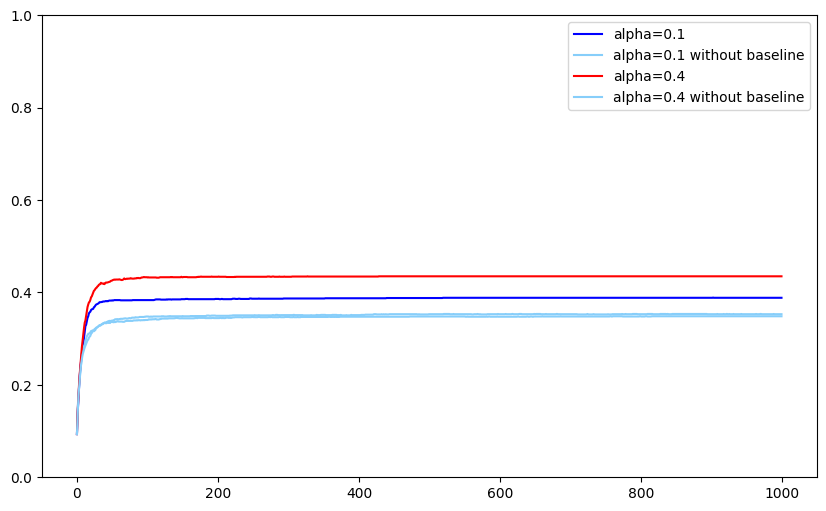

In [ ]:
plt.figure(figsize=(10, 6))
plt.ylim([0,1])
plt.plot(ac_sft_4_baseline, 'b', label='alpha=0.1')
plt.plot(ac_sft_4, 'lightskyblue', label='alpha=0.1 without baseline')
plt.plot(ac_sft_1_baseline, 'r', label='alpha=0.4')
plt.plot(ac_sft_1, 'lightskyblue', label='alpha=0.4 without baseline')
plt.legend()
plt.show()